# Overview

What separates the Hall of Fame from the Hall of Very Good? In this exploration, I look at the set of players who were nominated for entry into baseball's Hall of Fame. 

In this report, we find correlations among pitching, fielding, batting statistics, and awards with entry into the Hall of Fame. We also explore how they break down by position and explore whether or not the steroids era of baseball has had any effect.

TK: Add in conclusions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline
pd.set_option('display.max_columns', None)

# Data Wrangling
The dataset consists of pitching, hitting, and fielding statistics for Major League Baseball from 1871 through 2014. Each table is represented by a CSV file, with playerID being a unique ID we can use for merging.

To wrangle this data together, I performed the following steps:

* Load the Hall of Fame table.
* Merge in Master to add names.
* Merge in Award information.
* Merge in Appearances.
* Merge in Pitching statistics.
* Merge in Batting statistics.
* Merge in Fielding statistics.

## Master

In [2]:
hof_df = pd.read_csv('baseballdatabank-master/core/HallOfFame.csv')
master_df = pd.read_csv('baseballdatabank-master/core/Master.csv', parse_dates=['debut', 'finalGame'])

hof_cols = ['playerID', 'nameFirst', 'nameLast'] + list(hof_df.columns[1:]) 

hof_df = hof_df.merge(master_df, on='playerID')
hof_df = hof_df[hof_cols]

hof_df.head()

,playerID,nameFirst,nameLast,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,Ty,Cobb,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,Babe,Ruth,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,Honus,Wagner,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,wagneho01,Honus,Wagner,1936,Veterans,78.0,59.0,5.0,N,Player,NaN
4,mathech01,Christy,Mathewson,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN


Since each row in the Hall of Fame set reflects a voting record, we group by playerID to remove duplicate rows. We end up with a single data frame of players, where the `inducted` field marks whether or not they are in the Hall of Fame.

There are 247 inducted players and 941 non-inducted players in this dataset.

In [3]:
player_votes = hof_df.loc[(hof_df.category == 'Player')]
inducted_players = hof_df.loc[(hof_df.inducted == 'Y') & (hof_df.category == 'Player')]

non_inducted_ids = set(player_votes.playerID).difference(inducted_players.playerID)

non_inducted_players = player_votes.loc[hof_df.playerID.isin(non_inducted_ids)]
non_inducted_players = non_inducted_players.groupby('playerID', as_index=False).last()

print("# of Inducted Players: %d" % inducted_players.shape[0])
print("# of Non-Inducted Players: %d" % non_inducted_players.shape[0])

nominated_players = inducted_players.append(non_inducted_players, ignore_index=True)
display(nominated_players.shape)

# of Inducted Players: 247
# of Non-Inducted Players: 941


(1188, 11)

## Awards
We add in Awards players won over the course of their career. It seems plausible that awards would be correlated with entrance into the Hall.

In [4]:
awards = pd.read_csv("baseballdatabank-master/core/AwardsPlayers.csv")

award_count = awards.groupby('playerID').size().reset_index()
award_count.columns = ['playerID', 'Awards']

# Convert each award into a column, value will be the count.
award_columns = awards[['playerID', 'awardID']].pivot_table(index='playerID', columns='awardID', 
                                                            aggfunc=np.count_nonzero, fill_value=0)

nominated_players = pd.merge(nominated_players, award_columns.reset_index(), on='playerID', how='left')
nominated_players = pd.merge(nominated_players, award_count, on='playerID', how='left')

# Not all players will get awards, so fill missing values with 0. 
# Note: needed_note field will also get replaced, but I don't use this field, so it's okay.
nominated_players.fillna(0, inplace=True)

nominated_players.head()

,playerID,nameFirst,nameLast,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards
0,cobbty01,Ty,Cobb,1936,BBWAA,226.0,170.0,222.0,Y,Player,0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,31.0
1,ruthba01,Babe,Ruth,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0
2,wagneho01,Honus,Wagner,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
3,mathech01,Christy,Mathewson,1936,BBWAA,226.0,170.0,205.0,Y,Player,0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
4,johnswa01,Walter,Johnson,1936,BBWAA,226.0,170.0,189.0,Y,Player,0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0


Here, we separate players into two buckets, i.e. whether they are inducted or not. 

When we look at summary stasticis below, it seems like inducted players on average receive more awards than non-inducted players. 

In [5]:
display(nominated_players[nominated_players.inducted == 'Y'].Awards.describe())
display(nominated_players[nominated_players.inducted == 'N'].Awards.describe())

count    247.000000
mean       9.210526
std        9.297489
min        0.000000
25%        1.000000
50%        7.000000
75%       14.000000
max       39.000000
Name: Awards, dtype: float64

count    941.000000
mean       2.380446
std        3.611713
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       47.000000
Name: Awards, dtype: float64

When we visualize these using a histogram, we see that both distributions are skewed to the right. The largest bin for both represents winning just a few awards. However, the inducted players have a much longer tail, with a player winning 39 awards.

In [6]:
def plot_awards(df, title, bins=20):
    ax = df['Awards'].hist(bins=bins)
    ax.set_xlabel("Number of Awards")
    ax.set_ylabel("Count")
    ax.set_title(title)

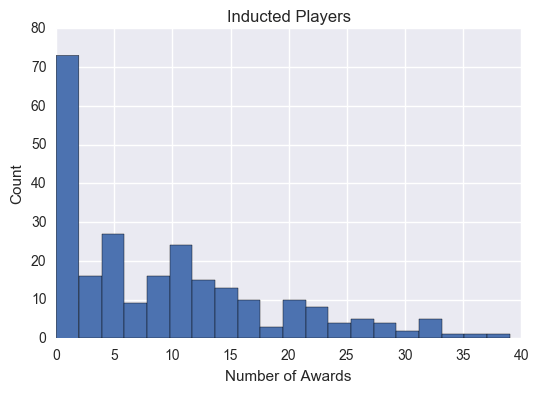

In [7]:
plot_awards(nominated_players[nominated_players.inducted == 'Y'], 'Inducted Players')

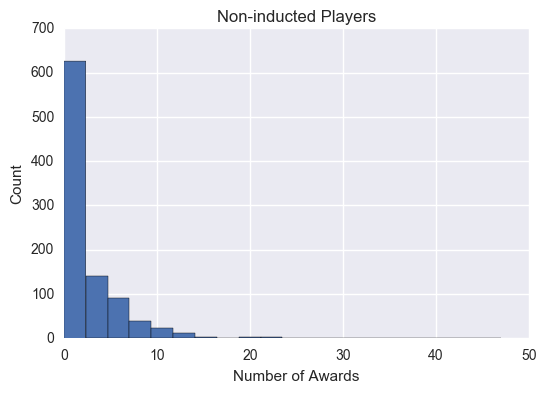

In [8]:
plot_awards(nominated_players[nominated_players.inducted == 'N'], 'Non-inducted Players')

# Appearances
Number of games played could approximate longevity, which Hall voters could be rewarding.

In [9]:
def cumulative_stats(csv_path, display_head=True, agg_dict=None):
    """Computes aggregate stats from a CSV.
    
    Loads a CSV denoted by csv_path, groups by playerID. By default, numeric
    columns will be summed unless functions are specified in agg_dict.
    """
    df = pd.read_csv(csv_path)
    
    if display_head == True:
        display(df.head())
    
    df_total = None
    
    if agg_dict is None:
        df_total = df.groupby('playerID', as_index=False).sum()
        del df_total['yearID']
    else:
        df_total = df.groupby('playerID', as_index=False).agg(agg_dict)
    
    return df_total

# Merge with Appearances
appearances_total = cumulative_stats("baseballdatabank-master/core/Appearances.csv", display_head=False)
appearances_total.fillna(0, inplace=True)

appearances_total.head()

,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,aardsda01,331.0,0.0,139,331.0,331,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
1,aaronha01,3298.0,288.0,3298,3057.0,0,0,210,43,7,0,313,293,2184,2760,196.0,46.0,0.0
2,aaronto01,437.0,0.0,437,437.0,0,0,232,7,10,0,136,1,2,138,0.0,0.0,0.0
3,aasedo01,448.0,0.0,81,448.0,448,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
4,abadan01,15.0,4.0,15,9.0,0,0,8,0,0,0,0,0,1,1,0.0,7.0,1.0


## Positions
We also use the appearances data to determine the player's most played position. We will use this to compare traits amongst players later.

In [10]:
nominated_players = pd.merge(nominated_players, appearances_total, on='playerID')

# position_cols = ['G_p','G_c','G_1b','G_2b',
#                  'G_3b','G_ss','G_lf','G_cf',
#                  'G_rf','G_of','G_dh','G_ph','G_pr']

position_cols = ['G_p','G_c','G_1b','G_2b',
                 'G_3b','G_ss','G_of','G_dh','G_ph','G_pr']

def most_played_position(df):
    return df[position_cols].idxmax(axis=1).str.split('_').str[1].str.upper()

nominated_players.insert(3, 'Position', most_played_position(nominated_players))
display(nominated_players.head())

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,cobbty01,Ty,Cobb,OF,1936,BBWAA,226.0,170.0,222.0,Y,Player,0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,31.0,3034.0,0.0,3034,3034.0,3,0,14,2,1,0,35,2194,706,2934,0.0,0.0,0.0
1,ruthba01,Babe,Ruth,OF,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,2503.0,0.0,2503,2503.0,163,0,32,0,0,0,1057,64,1131,2241,0.0,0.0,0.0
2,wagneho01,Honus,Wagner,SS,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2794.0,0.0,2794,2794.0,2,0,248,57,210,1887,35,67,272,373,0.0,0.0,0.0
3,mathech01,Christy,Mathewson,P,1936,BBWAA,226.0,170.0,205.0,Y,Player,0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,647.0,0.0,647,647.0,636,0,3,0,0,0,1,0,3,4,0.0,0.0,0.0
4,johnswa01,Walter,Johnson,P,1936,BBWAA,226.0,170.0,189.0,Y,Player,0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,934.0,0.0,934,934.0,802,0,0,0,0,0,2,7,4,13,0.0,0.0,0.0


Out of all the positions, we can see that pitchers are represented the most in our dataset:

In [11]:
nominated_players.Position.value_counts()

P     394
OF    297
C     101
1B    100
2B     88
3B     86
SS     84
DH      8
PH      4
Name: Position, dtype: int64

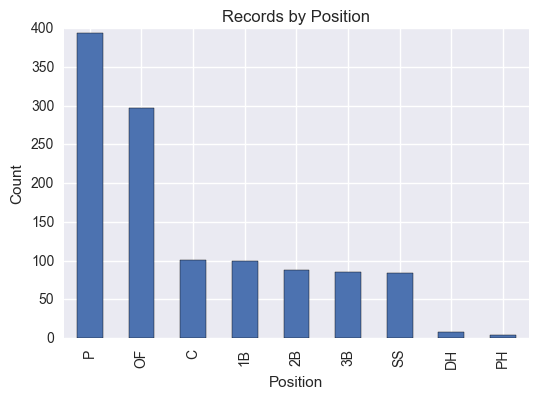

In [12]:
ax = nominated_players.Position.value_counts().plot.bar()
ax.set_title("Records by Position")
ax.set_ylabel("Count")
ax.set_xlabel("Position");

## Pitching

In [13]:
agg_dict = {'ERA': np.mean, 'W': np.sum, 'L': np.sum}
pitching_total = cumulative_stats("baseballdatabank-master/core/Pitching.csv", 
                                  display_head=False,
                                  agg_dict=agg_dict)

nominated_players = pd.merge(nominated_players, pitching_total, on='playerID', how='left')

## Batting
I merged in hitting statistics and computed the common sabermetric statistics of on-base percentage (OBP), slugging percentage (SLG), and on-base plus slugging (OPS).

In [14]:
def slugging_pct(df):
    return ((df['H'] - df['2B'] - df['3B'] - df['HR']) + 2*df['2B'] + 3*df['3B'] + 4*df['HR']) / df['AB']

def on_base_pct(df):
    return (df['H'] + df['BB'] + df['HBP']) / (df['AB'] + df['BB'] + df['SF'] + df['HBP'])

def on_base_plus_slugging(df):
    return on_base_pct(df) + slugging_pct(df)

def add_hitting_stats(df):
    df['BA'] = df.H / df.AB
    df['SLG'] = slugging_pct(df)
    df['OBP'] = on_base_pct(df)
    df['OPS'] = on_base_plus_slugging(df)

In [15]:
batting_total = cumulative_stats("baseballdatabank-master/core/Batting.csv", 
                                  display_head=False)

nominated_players = pd.merge(nominated_players, batting_total, on='playerID', how='left')

nominated_players.fillna(0, inplace=True)

add_hitting_stats(nominated_players)

# Fielding

In [16]:
fielding_total = cumulative_stats("baseballdatabank-master/core/Fielding.csv", display_head=False)

fielding_total['E/G'] = fielding_total['E'] / fielding_total['G']
fielding_total['ZR/G'] = fielding_total['ZR'] / fielding_total['G']

fielding_total.rename(columns = {'CS': 'Opponent CS', 'SB': 'Opponent SB'}, inplace = True)

nominated_players = pd.merge(nominated_players, fielding_total, on='playerID', how='left')

nominated_players.head()

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards,G_all,GS_x,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,ERA,W,L,stint_x,G_x,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,BA,SLG,OBP,OPS,stint_y,G_y,GS_y,InnOuts,PO,A,E,DP,PB,WP,Opponent SB,Opponent CS,ZR,E/G,ZR/G
0,cobbty01,Ty,Cobb,OF,1936,BBWAA,226.0,170.0,222.0,Y,Player,0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,31.0,3034.0,0.0,3034,3034.0,3,0,14,2,1,0,35,2194,706,2934,0.0,0.0,0.0,2.250000,0.0,0.0,24,3035,11434.0,2246.0,4189.0,724.0,295.0,117.0,1937.0,892.0,178.0,1249.0,357.0,0.0,94.0,295.0,0.0,0.0,0.366363,0.511982,0.432965,0.944947,31,2954,NaN,NaN,6507.0,410.0,278.0,113.0,NaN,NaN,NaN,NaN,NaN,0.094110,NaN
1,ruthba01,Babe,Ruth,OF,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,2503.0,0.0,2503,2503.0,163,0,32,0,0,0,1057,64,1131,2241,0.0,0.0,0.0,3.680000,94.0,46.0,22,2503,8398.0,2174.0,2873.0,506.0,136.0,714.0,2217.0,123.0,117.0,2062.0,1330.0,0.0,43.0,113.0,0.0,2.0,0.342105,0.689807,0.473960,1.163767,38,2436,NaN,NaN,4787.0,569.0,179.0,86.0,NaN,NaN,NaN,NaN,NaN,0.073481,NaN
2,wagneho01,Honus,Wagner,SS,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2794.0,0.0,2794,2794.0,2,0,248,57,210,1887,35,67,272,373,0.0,0.0,0.0,0.000000,0.0,0.0,21,2792,10430.0,1736.0,3415.0,640.0,252.0,101.0,1732.0,722.0,15.0,963.0,327.0,0.0,125.0,221.0,0.0,0.0,0.327421,0.466155,0.390953,0.857109,61,2775,NaN,NaN,7930.0,6781.0,825.0,963.0,NaN,NaN,NaN,NaN,NaN,0.297297,NaN
3,mathech01,Christy,Mathewson,P,1936,BBWAA,226.0,170.0,205.0,Y,Player,0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,647.0,0.0,647,647.0,636,0,3,0,0,0,1,0,3,4,0.0,0.0,0.0,2.648889,373.0,188.0,19,646,1684.0,151.0,362.0,50.0,12.0,7.0,165.0,20.0,1.0,116.0,74.0,0.0,17.0,69.0,0.0,0.0,0.214964,0.271378,0.272427,0.543805,21,642,NaN,NaN,313.0,1506.0,56.0,44.0,NaN,NaN,NaN,NaN,NaN,0.087227,NaN
4,johnswa01,Walter,Johnson,P,1936,BBWAA,226.0,170.0,189.0,Y,Player,0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,934.0,0.0,934,934.0,802,0,0,0,0,0,2,7,4,13,0.0,0.0,0.0,2.348095,417.0,279.0,21,933,2324.0,241.0,547.0,94.0,41.0,24.0,255.0,13.0,4.0,110.0,251.0,0.0,13.0,70.0,0.0,0.0,0.235370,0.342083,0.273805,0.615887,26,815,NaN,NaN,292.0,1352.0,53.0,72.0,NaN,NaN,NaN,NaN,NaN,0.065031,NaN


# Analysis

In [17]:
# Convert inducted Y/N to numeric for corrplot
def convert_inducted_to_numeric(s):
    if s == 'Y':
        return 1
    else:
        return 0

nominated_players['inducted'] = nominated_players['inducted'].apply(convert_inducted_to_numeric)

In [18]:
def corr_plot(corr, annot=False):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 7))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                square=True, xticklabels=corr.columns.values, 
                yticklabels=corr.columns.values, annot=annot,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

    ax.set_title("Correlation plot");

# Pitchers

Let's start by looking at pitchers.

Below we first list each statistic and its correlation with induction into the Hall of Fame. We also visualize this with a correlation plot.

The display below whos that Wins is most strongly correlated with entry into the Hall of Fame, followed by Losses and Awards. Losses seems counter-intuitive because we would expect this to be a negative trait. However, the correlation plot below shows that Wins and Losses are highly correlated (around 0.8). In other words, a pitcher who has a lot of wins will have more losses as well. 

Inducted           1.000000
Wins               0.611305
Losses             0.472997
Awards             0.472801
Errors             0.411778
Cy Young Award     0.261780
Games Played       0.261107
Batting Average    0.130200
ERA               -0.316926
Name: inducted, dtype: float64

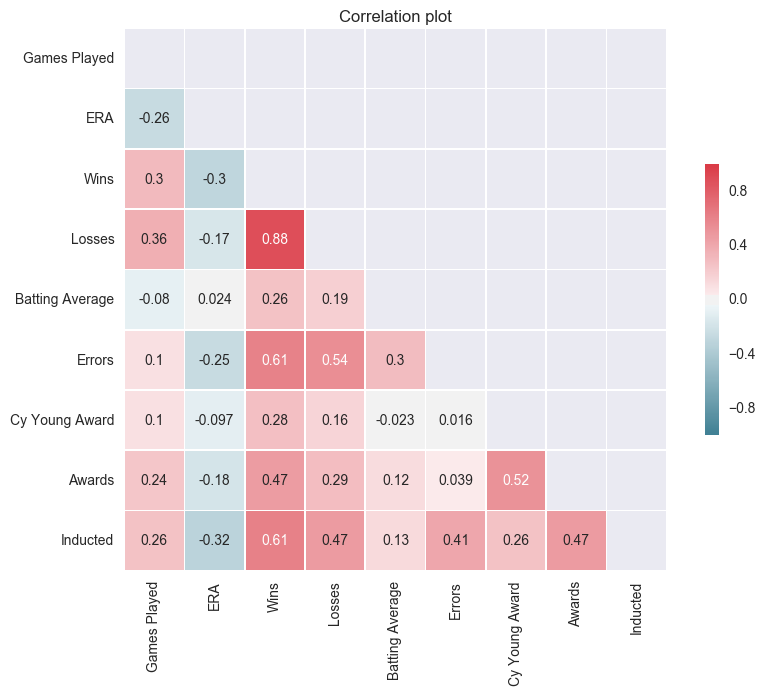

In [19]:
pitchers = nominated_players.loc[nominated_players.Position == 'P']

pitchers_corr = pitchers[['G_all', 'ERA', 'W', 'L', 'BA', 'E', 'Cy Young Award', 'Awards', 'inducted']].corr()
pitchers_corr.columns = ['Games Played', 'ERA', 'Wins', 'Losses', 'Batting Average', 'Errors', 'Cy Young Award', 'Awards', 'Inducted']

display(pitchers_corr.loc['inducted'].sort_values(ascending=False))
corr_plot(pitchers_corr, annot=True)

In [20]:
# TODO: look at pitchers by era, see if BA changes as a predictor
# Early Baseball is 1871 to 1949

# Non-Pitchers

Next, we'll look at the set of non-pitchers. We'll do a similar analysis as we did for pitchers, but we'll include more hitting and fielding statistics.

In [21]:
# Merge with Batting
non_pitchers = nominated_players.loc[nominated_players.Position != 'P']

In [29]:
def create_corr_df(df):
    fielding_cols = ['A', 'E', 'DP', 'PB', 'WP', 'Opponent SB', 'Opponent CS', 'ZR', 'E/G', 'ZR/G']
    batting_cols = ['R', 'RBI', 'HR', 'H', 'SB', 'SO', 'BA', 'SLG', 'OBP', 'OPS']
    other_cols = ['G_all', 'Awards']
    
    # Human readable versions of statistics.
    fielding_human = ['Assists', 'Errors', 'Double Plays', 'Passed Balls', 
                      'Wild Pitch', 'Opp. Stolen Bases', 'Opp. Caught Stealing',
                     'Zone Rating', 'Error / Game', 'Zone Rating / Game']
    batting_human = ['Runs', 'Runs Batted In', 'Home Runs', 
                        'Hits', 'Stolen Bases', 'Strike Outs', 'Batting Average', 
                        'On-base Percentage', 'Slugging Average', 'On-base Plus Slugging']
    other_human = ['Games', 'Awards']
    
    cols = other_cols + fielding_cols + batting_cols
    cols.append('inducted')
    
    corr = df[cols].corr()
    corr.columns = other_human + fielding_human + batting_human + ['Inducted']
    
    corr.index = list(corr.columns)
    
    return corr
    
def create_corr_plot(df, show_plot=True):
    corr = create_corr_df(df)
    
    display(corr.loc['inducted'].sort_values(ascending=False))
    if show_plot == True:
        corr_plot(corr)
    
    return corr

As shown below, the offensive statistics as well as game played have higher correlation with induction than any of the fielding statistics listed below.

I adjusted a couple of the fielding statistics to be rate statistics (e.g. Errors per Game instead of Errors), but these new statistics were even less correlated with induction.

This suggests there may be a bias towards offensive statistics when voters are looking at non-pitchers.

Inducted                 1.000000
Runs                     0.545905
Awards                   0.535053
Hits                     0.523258
Runs Batted In           0.492232
Batting Average          0.448893
Games                    0.406961
Slugging Average         0.400916
On-base Plus Slugging    0.390291
On-base Percentage       0.338724
Errors                   0.284245
Opp. Stolen Bases        0.279727
Stolen Bases             0.263113
Home Runs                0.238761
Opp. Caught Stealing     0.229041
Passed Balls             0.169859
Assists                  0.168195
Double Plays             0.157303
Wild Pitch               0.156271
Zone Rating              0.152955
Error / Game             0.068916
Strike Outs              0.036438
Zone Rating / Game      -0.005756
Name: inducted, dtype: float64

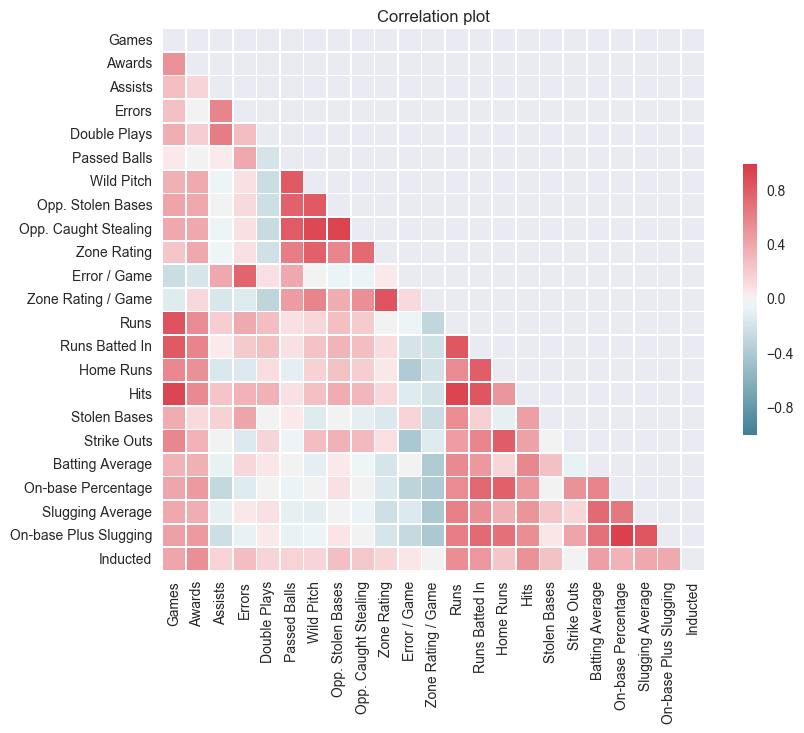

In [23]:
_ = create_corr_plot(non_pitchers)

In [33]:
positions = ['OF', 'C', '1B', '2B', '3B', 'SS']

correlations = []

for pos in positions:
    correlations.append(create_corr_df(non_pitchers.loc[non_pitchers.Position == pos])['Inducted'])
    
position_corr = pd.concat(correlations, axis=1)
position_corr.columns = positions

cmap = sns.diverging_palette(220, 10, as_cmap=True)

position_corr.style.background_gradient(cmap=cmap)

In [32]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

position_corr.style.background_gradient(cmap=cmap)

In [233]:
of = create_corr_df(non_pitchers.loc[non_pitchers.Position == 'OF'])['Inducted']
c = create_corr_df(non_pitchers.loc[non_pitchers.Position == 'C'])['Inducted']

#pd.concat(p, p2)
#display(p['Inducted'])
#display(p2['Inducted'])
pd.concat([of, c], axis=1)

,Inducted,Inducted
G_all,0.384984,0.399031
Awards,0.472270,0.631389
A,0.057061,0.288862
E,0.347747,0.180416
DP,0.100299,0.200555
PB,0.705965,0.094910
WP,NaN,0.100090
Opponent SB,NaN,0.246607
Opponent CS,NaN,0.204366
ZR,NaN,0.120910


### Correlations by Position
Let's break down non-pitchers by their position on the field and see if these correlations change at all. For brevity, we'll just use the display of the correlation statistics.

### Outfielders

Why does Passed Balls correlate strongly here? This is a catcher statistic.

TODO: exculde outfielders who played Catcher, ask how many outfielders played catcher? Maybe playing catcher actually correlates strongly too

In [207]:
_ = create_corr_plot(non_pitchers.loc[non_pitchers.Position == 'OF'], show_plot=False)

Inducted                 1.000000
Passed Balls             0.705965
Runs                     0.560562
Hits                     0.528835
Batting Average          0.481965
Runs Batted In           0.474844
Awards                   0.472270
Slugging Average         0.417288
On-base Plus Slugging    0.398995
Games                    0.384984
Errors                   0.347747
On-base Percentage       0.333031
Stolen Bases             0.238399
Home Runs                0.213302
Error / Game             0.126912
Double Plays             0.100299
Assists                  0.057061
Strike Outs             -0.018889
Wild Pitch                    NaN
Opp. Stolen Bases             NaN
Opp. Caught Stealing          NaN
Zone Rating                   NaN
Zone Rating / Game            NaN
Name: inducted, dtype: float64

### Catchers

In [208]:
_ = create_corr_plot(non_pitchers.loc[non_pitchers.Position == 'C'], show_plot=False)

Inducted                 1.000000
Awards                   0.631389
Runs Batted In           0.591491
Runs                     0.588230
On-base Plus Slugging    0.510052
On-base Percentage       0.502441
Hits                     0.496819
Home Runs                0.494682
Slugging Average         0.426341
Batting Average          0.402330
Games                    0.399031
Stolen Bases             0.293404
Assists                  0.288862
Opp. Stolen Bases        0.246607
Opp. Caught Stealing     0.204366
Double Plays             0.200555
Errors                   0.180416
Strike Outs              0.142733
Zone Rating              0.120910
Wild Pitch               0.100090
Passed Balls             0.094910
Error / Game            -0.040726
Zone Rating / Game      -0.091960
Name: inducted, dtype: float64

### First Base

In [210]:
_ = create_corr_plot(non_pitchers.loc[non_pitchers.Position == '1B'], show_plot=False)

Inducted                 1.000000
Runs                     0.553022
Runs Batted In           0.528945
Hits                     0.477404
Batting Average          0.475765
On-base Plus Slugging    0.463361
Errors                   0.435633
On-base Percentage       0.427247
Slugging Average         0.410915
Awards                   0.387126
Assists                  0.356788
Games                    0.342032
Stolen Bases             0.255670
Error / Game             0.248210
Home Runs                0.247375
Double Plays             0.225104
Passed Balls             0.116275
Strike Outs              0.061700
Wild Pitch                    NaN
Opp. Stolen Bases             NaN
Opp. Caught Stealing          NaN
Zone Rating                   NaN
Zone Rating / Game            NaN
Name: inducted, dtype: float64

#### Second Base

In [211]:
_ = create_corr_plot(non_pitchers.loc[non_pitchers.Position == '2B'], show_plot=False)

Inducted                 1.000000
Zone Rating              1.000000
Wild Pitch               1.000000
Opp. Stolen Bases        1.000000
Opp. Caught Stealing     1.000000
Zone Rating / Game       1.000000
Passed Balls             0.857816
Awards                   0.715629
Runs Batted In           0.646818
Hits                     0.644631
Runs                     0.642920
Assists                  0.616043
Games                    0.569471
Double Plays             0.550832
On-base Plus Slugging    0.519868
On-base Percentage       0.483052
Batting Average          0.447598
Slugging Average         0.441782
Home Runs                0.412602
Stolen Bases             0.344925
Errors                   0.271817
Strike Outs              0.107471
Error / Game            -0.066583
Name: inducted, dtype: float64

#### Third Base

In [213]:
_ = create_corr_plot(non_pitchers.loc[non_pitchers.Position == '3B'], show_plot=False)

Inducted                 1.000000
Passed Balls             0.788142
Awards                   0.598052
Hits                     0.498727
Batting Average          0.491384
Runs                     0.475953
Runs Batted In           0.441174
On-base Plus Slugging    0.364685
Games                    0.347225
On-base Percentage       0.324607
Assists                  0.323551
Slugging Average         0.302273
Errors                   0.240369
Home Runs                0.199242
Double Plays             0.178187
Strike Outs              0.039843
Error / Game             0.035455
Stolen Bases             0.014135
Wild Pitch                    NaN
Opp. Stolen Bases             NaN
Opp. Caught Stealing          NaN
Zone Rating                   NaN
Zone Rating / Game            NaN
Name: inducted, dtype: float64

#### Shortstop

In [214]:
_ = create_corr_plot(non_pitchers.loc[non_pitchers.Position == 'SS'], show_plot=False)

Inducted                 1.000000
Runs Batted In           0.615088
Awards                   0.597929
Runs                     0.590667
Hits                     0.576378
Slugging Average         0.467495
Games                    0.466557
Batting Average          0.464122
Assists                  0.446932
On-base Plus Slugging    0.437156
Errors                   0.392731
On-base Percentage       0.358905
Stolen Bases             0.354597
Double Plays             0.340276
Home Runs                0.226031
Error / Game             0.151643
Strike Outs             -0.057777
Passed Balls                  NaN
Wild Pitch                    NaN
Opp. Stolen Bases             NaN
Opp. Caught Stealing          NaN
Zone Rating                   NaN
Zone Rating / Game            NaN
Name: inducted, dtype: float64

# Correlations by Positions
Let's break down non-pitchers further and see if these correlations change at all.

Top 5 correlations for each:

* OF: Runs, Hits, RBI, Batting Average, RBI
* SS: RBI, Awards, Runs, Hits, Slugging Average
* 2B: Awards, RBI, Hits, Runs, Games Played
* C: Awards, RBI, Runs, OPS, OBP
* 1B: Runs, RBI, Hits, Batting Average, OPS
* 3B: Awards, Hits, BA, Runs, RBI
* DH: Runs, Awards, Hits, RBI, SB

In [72]:
non_pitchers.Position.unique()

array(['OF', 'SS', '2B', 'C', '1B', '3B', 'DH', 'PH', 'LF', 'CF'], dtype=object)

OF
(297, 97)


Inducted                 1.000000
Runs                     0.560562
Hits                     0.528835
Batting Average          0.481965
Runs Batted In           0.474844
Awards                   0.472270
Slugging Average         0.417288
On-base Plus Slugging    0.398995
Games Played             0.384984
On-base Percentage       0.333031
Stolen Bases             0.238399
Home Runs                0.213302
Strike Outs              0.018889
Name: inducted, dtype: float64

inducted       1.000000
PB             0.705965
E              0.347747
E/G            0.126912
DP             0.100299
A              0.057061
WP                  NaN
Opponent SB         NaN
Opponent CS         NaN
ZR                  NaN
ZR/G                NaN
Name: inducted, dtype: float64

SS
(84, 97)


Inducted                 1.000000
Runs Batted In           0.615088
Awards                   0.597929
Runs                     0.590667
Hits                     0.576378
Slugging Average         0.467495
Games Played             0.466557
Batting Average          0.464122
On-base Plus Slugging    0.437156
On-base Percentage       0.358905
Stolen Bases             0.354597
Home Runs                0.226031
Strike Outs              0.057777
Name: inducted, dtype: float64

inducted       1.000000
A              0.446932
E              0.392731
DP             0.340276
E/G            0.151643
PB                  NaN
WP                  NaN
Opponent SB         NaN
Opponent CS         NaN
ZR                  NaN
ZR/G                NaN
Name: inducted, dtype: float64

2B
(88, 97)


Inducted                 1.000000
Awards                   0.715629
Runs Batted In           0.646818
Hits                     0.644631
Runs                     0.642920
Games Played             0.569471
On-base Plus Slugging    0.519868
On-base Percentage       0.483052
Batting Average          0.447598
Slugging Average         0.441782
Home Runs                0.412602
Stolen Bases             0.344925
Strike Outs              0.107471
Name: inducted, dtype: float64

inducted       1.000000
ZR/G           1.000000
ZR             1.000000
Opponent CS    1.000000
Opponent SB    1.000000
WP             1.000000
PB             0.857816
A              0.616043
DP             0.550832
E              0.271817
E/G            0.066583
Name: inducted, dtype: float64

C
(101, 97)


Inducted                 1.000000
Awards                   0.631389
Runs Batted In           0.591491
Runs                     0.588230
On-base Plus Slugging    0.510052
On-base Percentage       0.502441
Hits                     0.496819
Home Runs                0.494682
Slugging Average         0.426341
Batting Average          0.402330
Games Played             0.399031
Stolen Bases             0.293404
Strike Outs              0.142733
Name: inducted, dtype: float64

inducted       1.000000
A              0.288862
Opponent SB    0.246607
Opponent CS    0.204366
DP             0.200555
E              0.180416
ZR             0.120910
WP             0.100090
PB             0.094910
ZR/G           0.091960
E/G            0.040726
Name: inducted, dtype: float64

1B
(100, 97)


Inducted                 1.000000
Runs                     0.553022
Runs Batted In           0.528945
Hits                     0.477404
Batting Average          0.475765
On-base Plus Slugging    0.463361
On-base Percentage       0.427247
Slugging Average         0.410915
Awards                   0.387126
Games Played             0.342032
Stolen Bases             0.255670
Home Runs                0.247375
Strike Outs              0.061700
Name: inducted, dtype: float64

inducted       1.000000
E              0.435633
A              0.356788
E/G            0.248210
DP             0.225104
PB             0.116275
WP                  NaN
Opponent SB         NaN
Opponent CS         NaN
ZR                  NaN
ZR/G                NaN
Name: inducted, dtype: float64

3B
(86, 97)


Inducted                 1.000000
Awards                   0.598052
Hits                     0.498727
Batting Average          0.491384
Runs                     0.475953
Runs Batted In           0.441174
On-base Plus Slugging    0.364685
Games Played             0.347225
On-base Percentage       0.324607
Slugging Average         0.302273
Home Runs                0.199242
Strike Outs              0.039843
Stolen Bases             0.014135
Name: inducted, dtype: float64

inducted       1.000000
PB             0.788142
A              0.323551
E              0.240369
DP             0.178187
E/G            0.035455
WP                  NaN
Opponent SB         NaN
Opponent CS         NaN
ZR                  NaN
ZR/G                NaN
Name: inducted, dtype: float64

DH
(8, 97)


Inducted                 1.000000
Runs                     0.785281
Awards                   0.666073
Hits                     0.623047
Runs Batted In           0.508401
Stolen Bases             0.467663
Batting Average          0.456517
Strike Outs              0.454728
Slugging Average         0.429113
On-base Plus Slugging    0.429059
On-base Percentage       0.401477
Home Runs                0.396750
Games Played             0.358790
Name: inducted, dtype: float64

inducted       1.000000
DP             0.837302
A              0.654115
E              0.642263
E/G            0.511707
PB                  NaN
WP                  NaN
Opponent SB         NaN
Opponent CS         NaN
ZR                  NaN
ZR/G                NaN
Name: inducted, dtype: float64

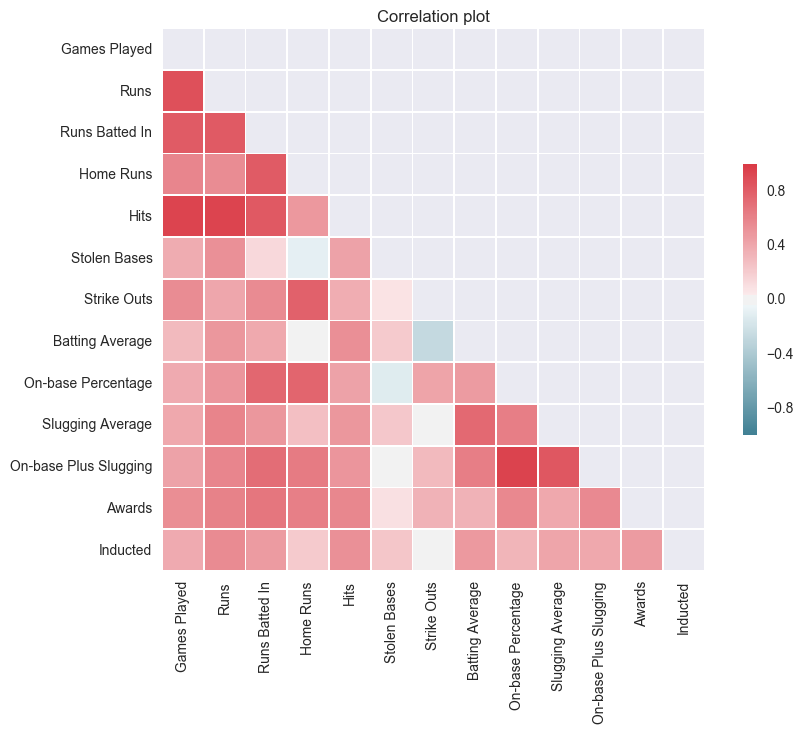

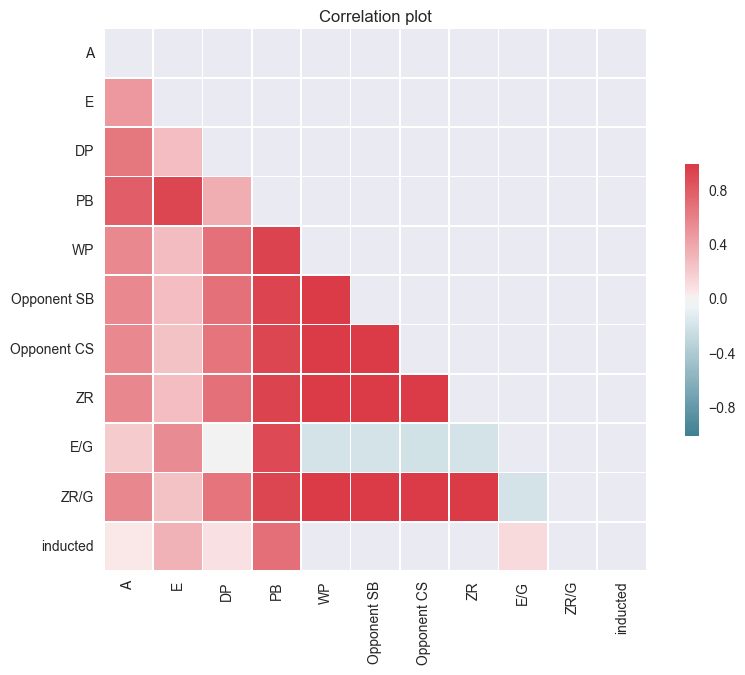

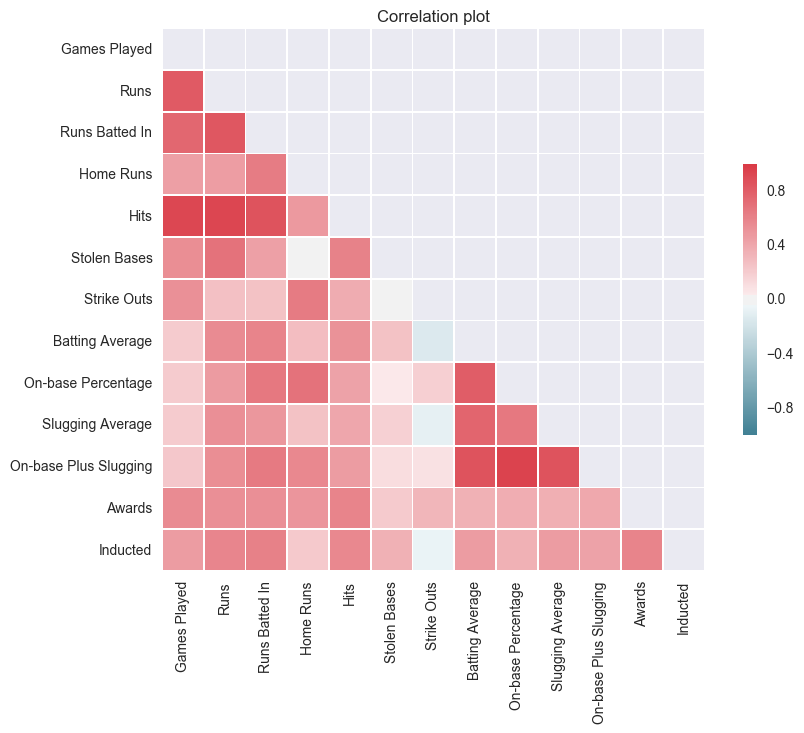

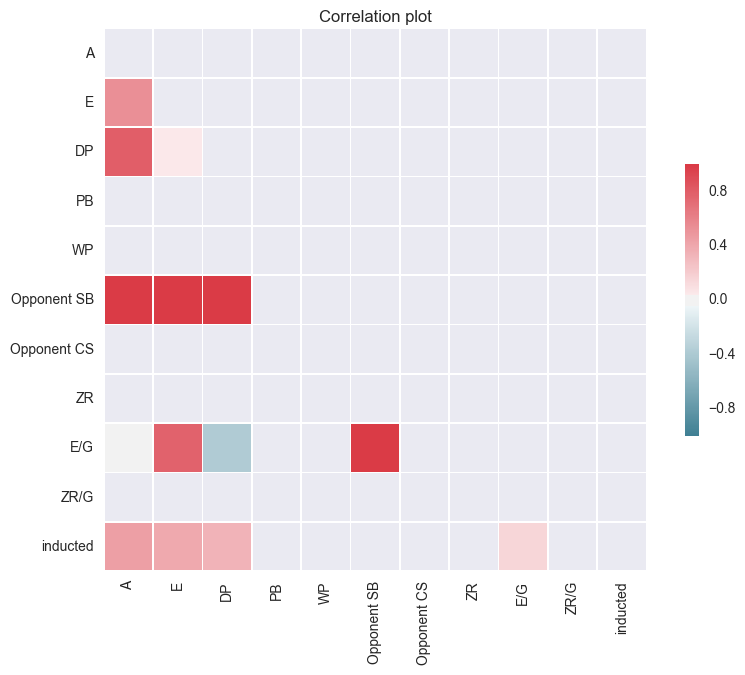

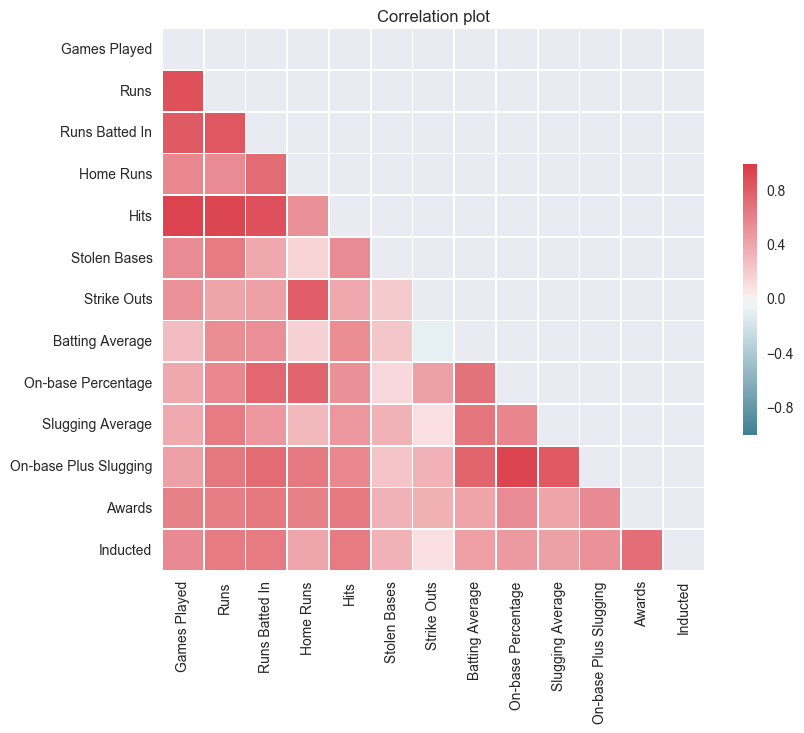

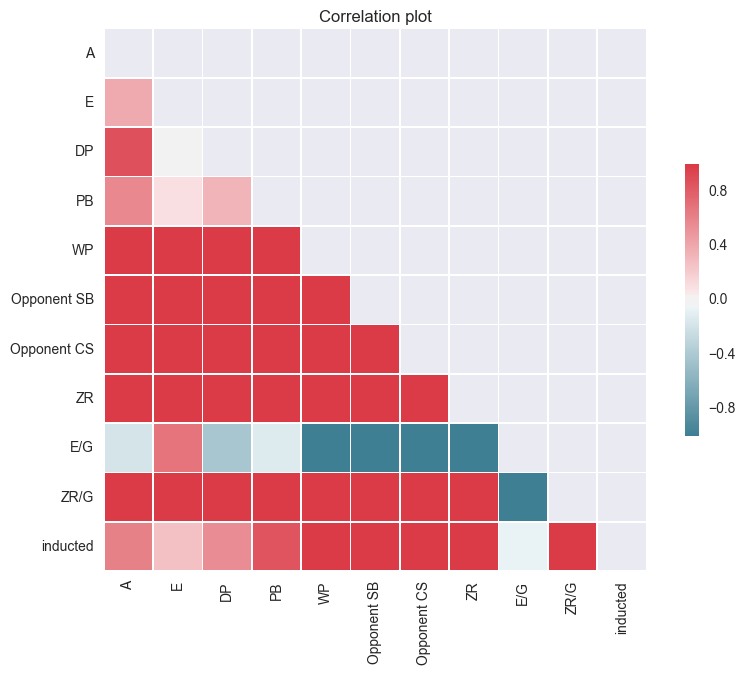

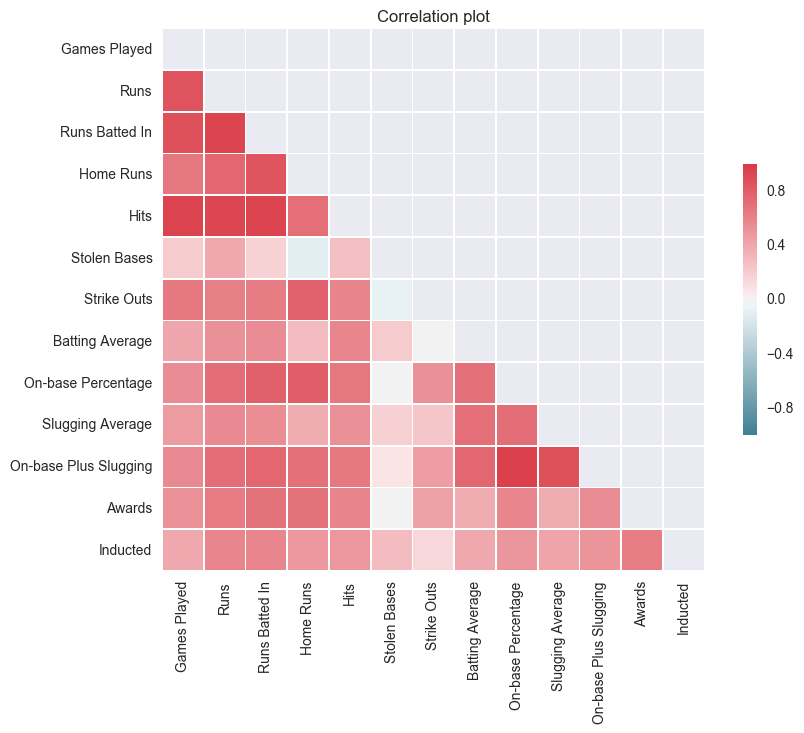

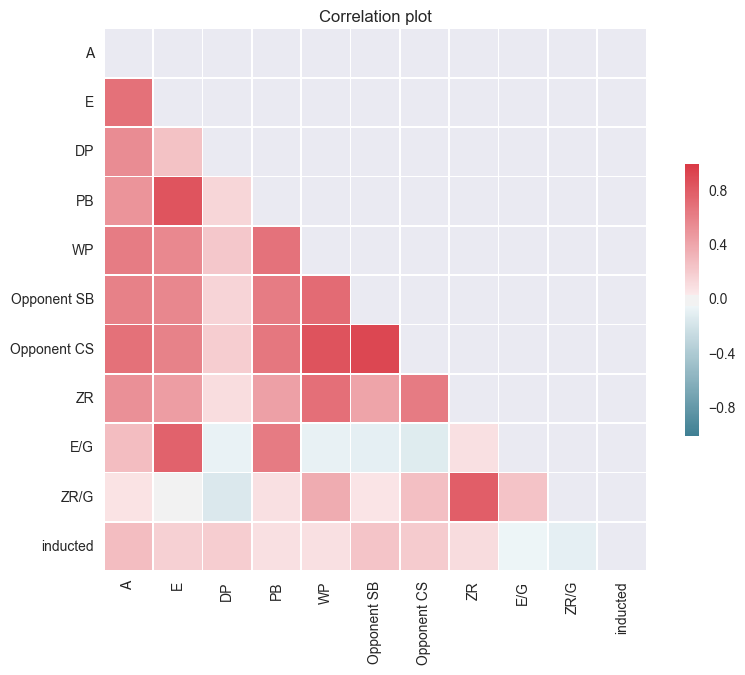

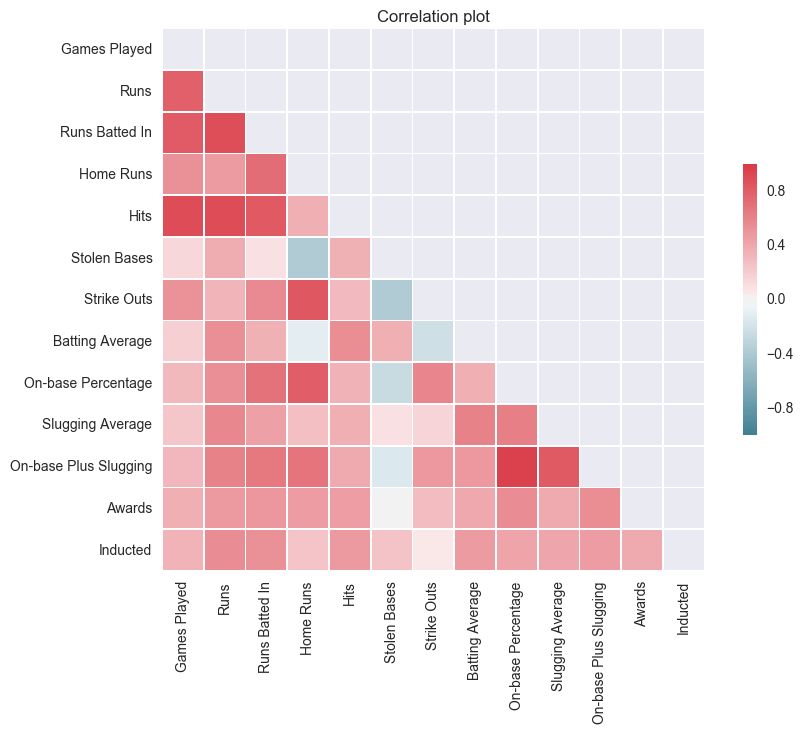

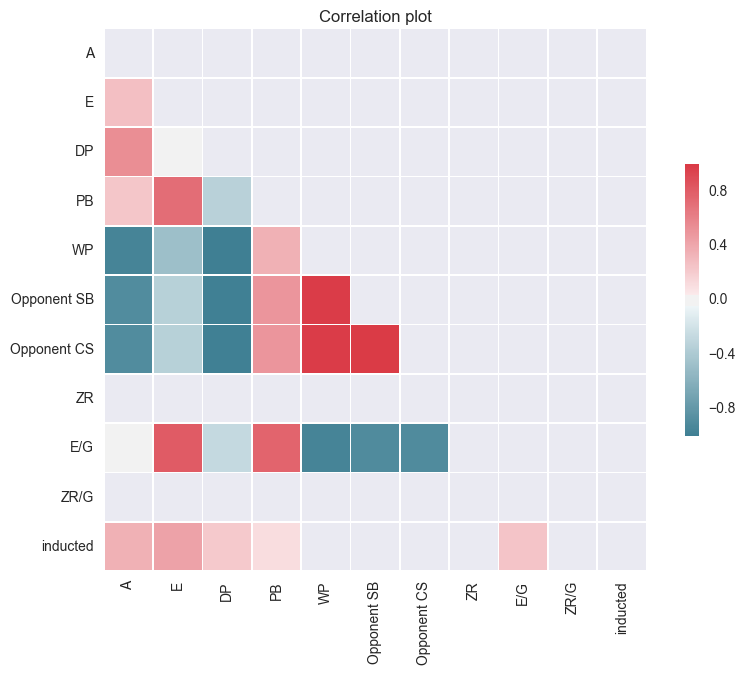

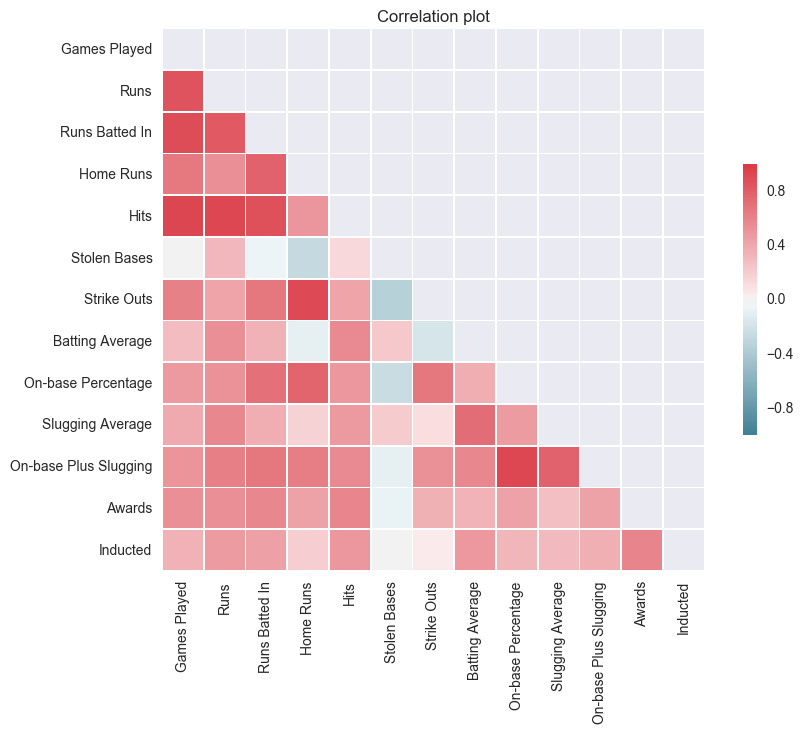

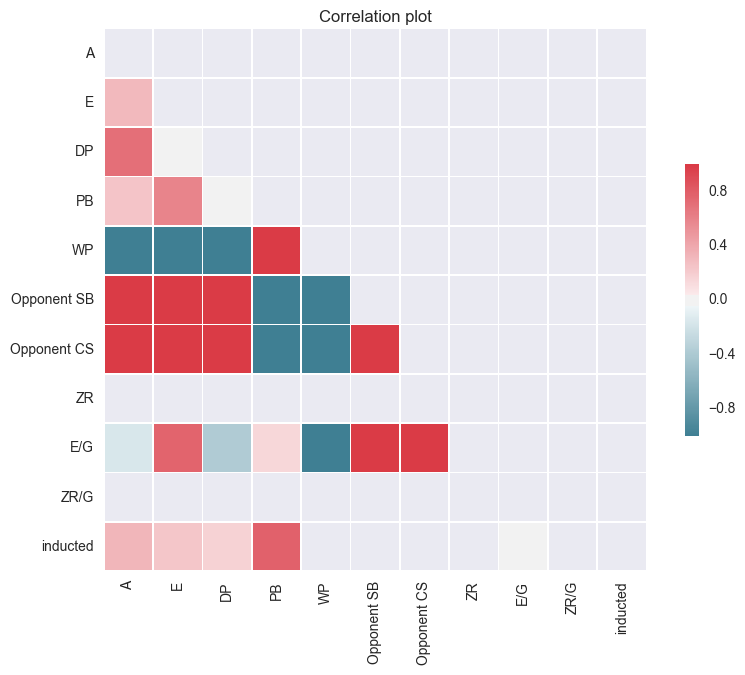

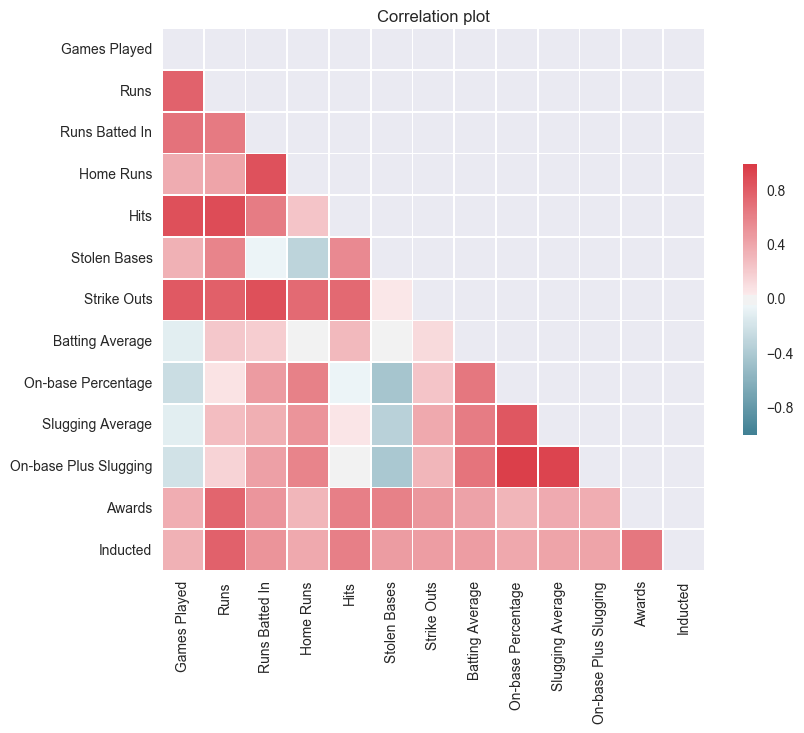

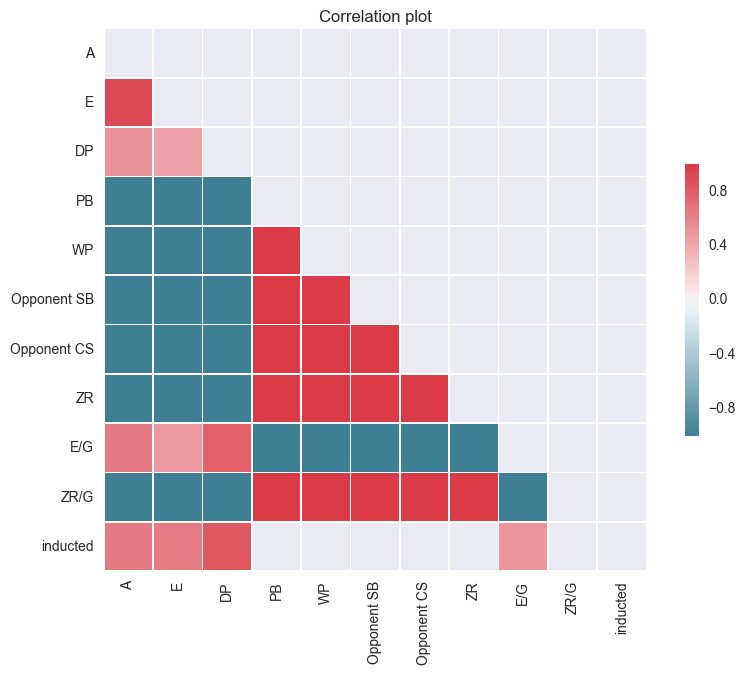

In [170]:
positions = ['OF', 'SS', '2B', 'C', '1B', '3B', 'DH']

for pos in positions:
    print(pos)
    print(non_pitchers.loc[non_pitchers.Position == pos].shape)
    batting_corr_plot(non_pitchers.loc[non_pitchers.Position == pos])
    fielding_corr_plot(non_pitchers.loc[non_pitchers.Position == pos])

In [78]:
non_pitchers.loc[(non_pitchers.Position == 'OF') & (non_pitchers['PB'] > 0)]

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards,G_all,GS_x,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,ERA,W,L,stint_x,G_x,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,BA,SLG,OBP,OPS,stint_y,G_y,GS_y,InnOuts,PO,A,E,DP,PB,WP,Opponent SB,Opponent CS,ZR,E/G,ZR/G
25,kellyki01,King,Kelly,OF,1945,Old Timers,0.0,0.0,0.0,1,Player,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1455.0,0.0,1455,1455.0,12,583,25,54,96,90,2,8,742,750,0.0,0.0,0.0,3.311429,2.0,2.0,21,1455,5894.0,1357.0,1813.0,359.0,102.0,69.0,950.0,368.0,0.0,549.0,418.0,0.0,12.0,0.0,0.0,0.0,0.307601,0.438242,0.367777,0.806019,82,1610,NaN,NaN,3572.0,1749.0,851.0,145.0,417.0,NaN,NaN,NaN,NaN,0.528571,NaN
92,orourji01,Jim,O'Rourke,OF,1945,Old Timers,0.0,0.0,0.0,1,Player,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999.0,0.0,1999,1999.0,6,231,214,2,148,40,770,463,217,1443,0.0,0.0,0.0,4.635000,0.0,1.0,23,1999,8505.0,1729.0,2643.0,465.0,151.0,62.0,1203.0,224.0,8.0,510.0,360.0,0.0,36.0,0.0,0.0,0.0,0.310758,0.422810,0.352337,0.775147,72,2079,NaN,NaN,5485.0,947.0,696.0,170.0,196.0,NaN,NaN,NaN,NaN,0.334776,NaN
262,bauerha01,Hank,Bauer,OF,1967,Run Off,306.0,219.0,9.0,0,Player,1st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1544.0,0.0,1544,1544.0,0,1,0,0,0,0,177,29,1292,1449,0.0,0.0,0.0,0.000000,0.0,0.0,14,1544,5145.0,833.0,1424.0,229.0,57.0,164.0,703.0,50.0,33.0,521.0,638.0,11.0,34.0,51.0,25.0,95.0,0.276774,0.439067,0.345677,0.784744,31,2328,1492.0,40159.0,3710.0,157.0,76.0,28.0,1.0,0.0,0.0,0.0,0.0,0.032646,0.000000
356,cartyri01,Rico,Carty,OF,1985,BBWAA,395.0,297.0,1.0,0,Player,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1651.0,653.0,1651,1004.0,0,17,59,0,1,0,789,1,18,807,598.0,53.0,0.0,0.000000,0.0,0.0,22,1651,5606.0,712.0,1677.0,278.0,17.0,204.0,890.0,21.0,26.0,642.0,663.0,65.0,13.0,3.0,54.0,206.0,0.299144,0.463967,0.369279,0.833247,47,2342,1642.0,40572.0,3116.0,98.0,96.0,57.0,2.0,5.0,6.0,5.0,0.0,0.040991,0.000000
692,langebi01,Bill,Lange,OF,1953,BBWAA,264.0,198.0,1.0,0,Player,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,813.0,0.0,813,813.0,0,8,16,57,9,9,15,702,2,718,0.0,0.0,0.0,0.000000,0.0,0.0,7,811,3195.0,689.0,1055.0,133.0,80.0,39.0,578.0,399.0,0.0,350.0,86.0,0.0,25.0,39.0,0.0,0.0,0.330203,0.458529,0.400560,0.859089,16,815,NaN,NaN,2108.0,387.0,183.0,76.0,7.0,NaN,NaN,NaN,NaN,0.224540,NaN
819,motama01,Manny,Mota,OF,1989,BBWAA,447.0,336.0,9.0,0,Player,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1536.0,8.0,1536,1244.0,0,1,0,6,15,0,726,270,118,1022,0.0,300.0,0.0,0.000000,0.0,0.0,22,1536,3779.0,496.0,1149.0,125.0,52.0,31.0,438.0,50.0,42.0,289.0,320.0,43.0,28.0,95.0,36.0,99.0,0.304049,0.389256,0.354792,0.744048,72,2160,1577.0,44584.0,2920.0,141.0,68.0,29.0,2.0,0.0,0.0,0.0,0.0,0.031481,0.000000
827,murphda05,Dale,Murphy,OF,2013,BBWAA,569.0,427.0,106.0,0,Player,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,2.0,4.0,0.0,0.0,2.0,0.0,0.0,8.0,8.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,19.0,2180.0,2107.0,2180,2142.0,0,85,209,0,0,0,103,1041,749,1854,0.0,55.0,2.0,0.000000,0.0,0.0,20

## Steroids Era Analysis

In [79]:
non_pitchers = pd.merge(non_pitchers, master_df[['playerID', 'finalGame']], on='playerID')

In [80]:
non_pitchers['Final Year'] = pd.DatetimeIndex(non_pitchers['finalGame']).year
sum((non_pitchers['Final Year'] - 1994) >= 5)

128

In [81]:
non_steroids_era = non_pitchers.loc[non_pitchers['Final Year'] - 1994 < 5]
steroids_era = non_pitchers.loc[non_pitchers['Final Year'] - 1994 >= 5]

display(non_steroids_era.shape)
display(steroids_era.shape)

(640, 99)

(128, 99)

Strike Outs              0.107125
Stolen Bases             0.277262
Home Runs                0.327522
On-base Percentage       0.427277
Slugging Average         0.428173
Games Played             0.441952
On-base Plus Slugging    0.460672
Batting Average          0.467331
Awards                   0.549761
Hits                     0.558178
Runs Batted In           0.568051
Runs                     0.593983
Inducted                 1.000000
Name: inducted, dtype: float64

ZR/G           0.035280
E/G            0.039757
A              0.155641
PB             0.176241
DP             0.179603
WP             0.207984
ZR             0.230902
Opponent SB    0.266087
E              0.268064
Opponent CS    0.282128
inducted       1.000000
Name: inducted, dtype: float64

,A,E,DP,PB,WP,Opponent SB,Opponent CS,ZR,E/G,ZR/G,inducted
A,1.000000,0.611365,0.650561,0.077164,0.009410,0.013174,0.019385,0.026792,0.396052,-0.110927,0.155641
E,0.611365,1.000000,0.323625,0.401898,0.156665,0.161846,0.164448,0.145458,0.752930,-0.094292,0.268064
DP,0.650561,0.323625,1.000000,-0.151638,-0.162116,-0.158573,-0.165031,-0.157047,0.116181,-0.263499,0.179603
PB,0.077164,0.401898,-0.151638,1.000000,0.839392,0.773320,0.802710,0.634821,0.400107,0.462649,0.176241
WP,0.009410,0.156665,-0.162116,0.839392,1.000000,0.919509,0.949932,0.817457,0.016892,0.602846,0.207984
Opponent SB,0.013174,0.161846,-0.158573,0.773320,0.919509,1.000000,0.975543,0.719462,-0.017893,0.487880,0.266087
Opponent CS,0.019385,0.164448,-0.165031,0.802710,0.949932,0.975543,1.000000,0.818800,-0.002606,0.583818,0.282128
ZR,0.026792,0.145458,-0.157047,0.634821,0.817457,0.719462,0.818800,1.000000,0.087406,0.837607,0.230902
E/G,0.396052,0.752930,0.116181,0.400107,0.016892,-0.017893,-0.002606,0.087406,1.000000,0.186151,0.039757
ZR/G,-0.110927,-0.094292,-0.263499,0.462649,0.602846,0.487880,0.583818,0.837607,0.186151,1.000000,0.035280


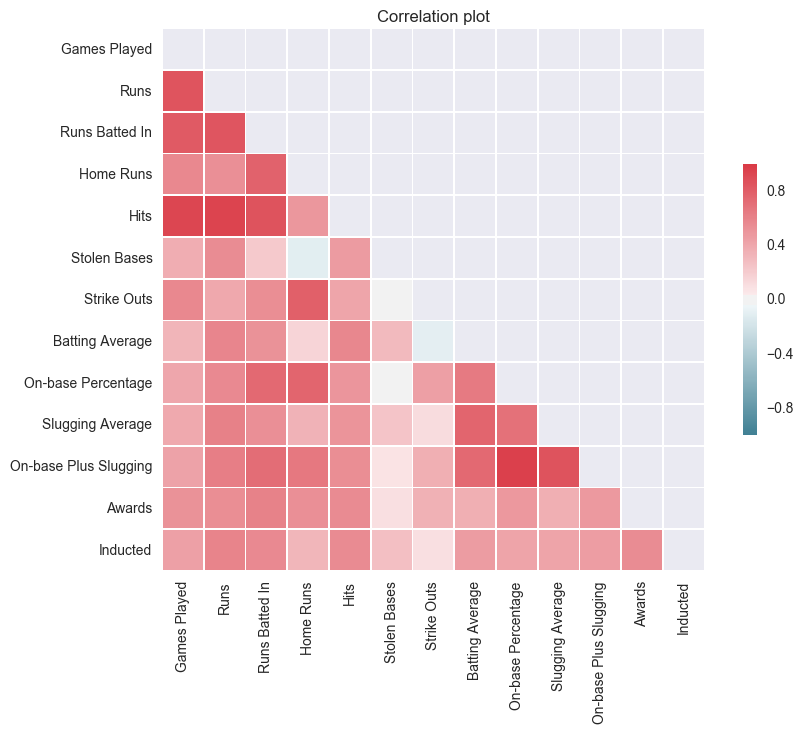

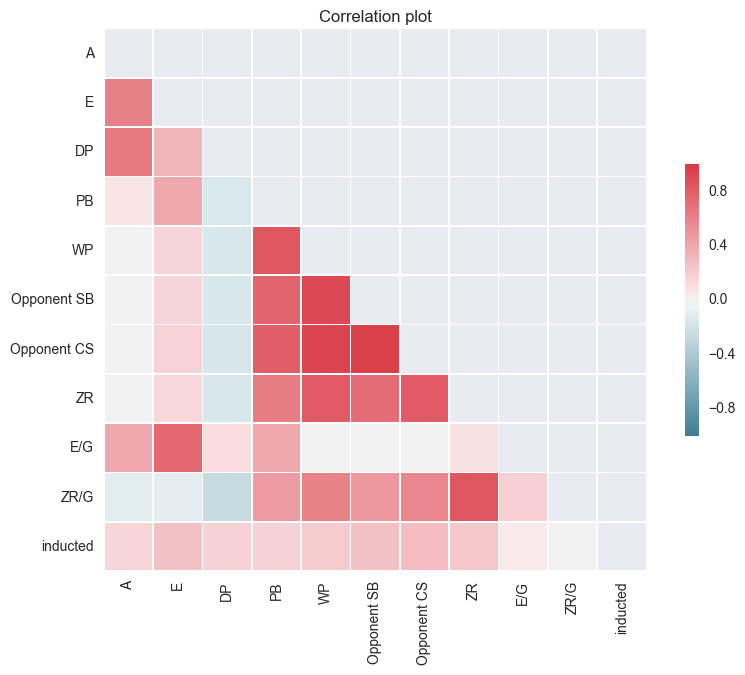

In [85]:
non_steroids_corr = batting_corr_plot(non_steroids_era)
fielding_corr_plot(non_steroids_era)

Strike Outs              0.088456
On-base Percentage       0.089703
Home Runs                0.159846
On-base Plus Slugging    0.180214
Runs Batted In           0.260480
Stolen Bases             0.276848
Slugging Average         0.301905
Batting Average          0.318515
Games Played             0.405887
Runs                     0.464748
Hits                     0.486375
Awards                   0.613070
Inducted                 1.000000
Name: inducted, dtype: float64

Opponent CS    0.012099
WP             0.020455
PB             0.053347
E/G            0.061150
ZR             0.085632
ZR/G           0.105649
DP             0.106853
A              0.261737
E              0.287917
Opponent SB    0.292576
inducted       1.000000
Name: inducted, dtype: float64

,A,E,DP,PB,WP,Opponent SB,Opponent CS,ZR,E/G,ZR/G,inducted
A,1.000000,0.661216,0.589391,-0.310767,-0.242249,-0.257590,-0.356450,-0.137000,0.733520,-0.183775,0.261737
E,0.661216,1.000000,0.269559,-0.134790,-0.142921,-0.160407,-0.280090,0.039557,0.640733,-0.031636,0.287917
DP,0.589391,0.269559,1.000000,-0.642201,-0.499946,-0.616005,-0.692440,-0.282735,0.404674,-0.328635,0.106853
PB,-0.310767,-0.134790,-0.642201,1.000000,0.775172,0.862450,0.877852,0.780398,-0.209272,0.793910,0.053347
WP,-0.242249,-0.142921,-0.499946,0.775172,1.000000,0.607982,0.762398,0.662902,-0.244455,0.671495,-0.020455
Opponent SB,-0.257590,-0.160407,-0.616005,0.862450,0.607982,1.000000,0.915472,0.413837,-0.293704,0.430556,0.292576
Opponent CS,-0.356450,-0.280090,-0.692440,0.877852,0.762398,0.915472,1.000000,0.533125,-0.394271,0.553703,0.012099
ZR,-0.137000,0.039557,-0.282735,0.780398,0.662902,0.413837,0.533125,1.000000,-0.035832,0.988005,-0.085632
E/G,0.733520,0.640733,0.404674,-0.209272,-0.244455,-0.293704,-0.394271,-0.035832,1.000000,-0.066769,0.061150
ZR/G,-0.183775,-0.031636,-0.328635,0.793910,0.671495,0.430556,0.553703,0.988005,-0.066769,1.000000,-0.105649


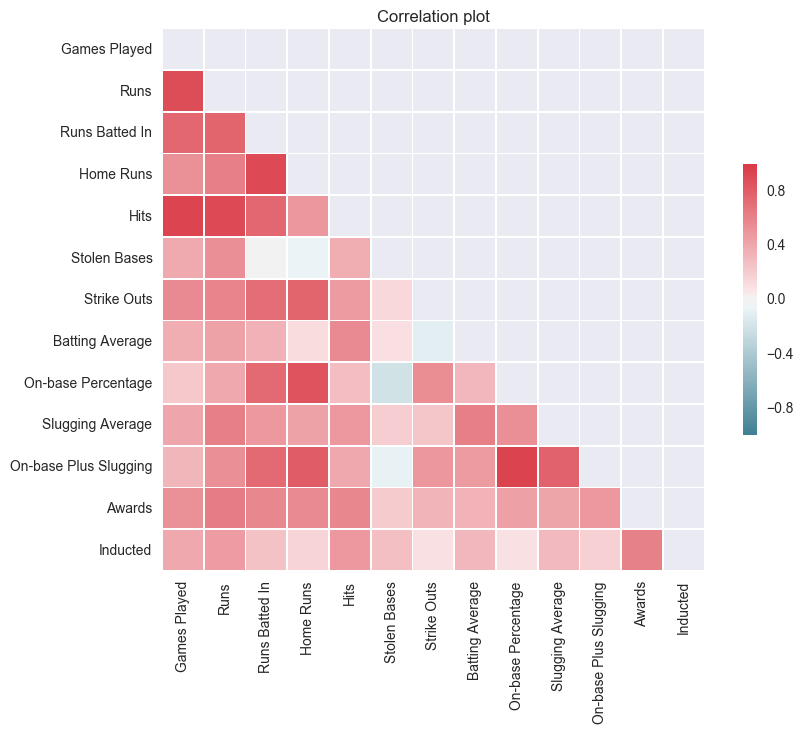

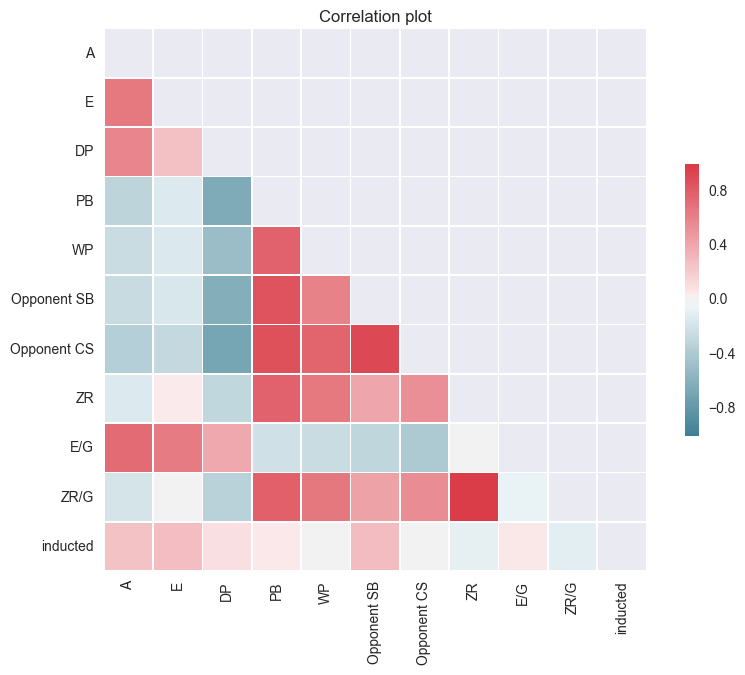

In [84]:
steroids_corr = batting_corr_plot(steroids_era)
fielding_corr_plot(steroids_era)

In [ ]:
steroids_corr['Inducted'] - non_steroids_corr['Inducted']

In [ ]:
# TODO: investigate whether there is a backlog in the Hall of Fame
# How many players get voted in per year?

# Conclusion
For pitchers, cumulative statistics such as wins and number of awards were most correlated with induction into the Hall of Fame. 
For non-pitchers, runs scored, hits, and awards were the most highly correlated with induction.

There are other directions I'd like to go in with this analysis:

* (/) Add more player data, including fielding statistics. 
* Compare players voted in by different methods. Are there differences between players voted in via the Baseball Writers vs. the Veterans Committee?
* Compare players from different eras. The modern game is dominated by newer metrics of player performance. Have voters opinions changed as a result of this?